In [1]:
import torch
import torch.nn.functional as F
import torch_geometric
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch_geometric
from tqdm import tqdm

# QM9をグラフ構造にしたもの
dataset = torch_geometric.datasets.qm9.QM9(root="./QM9") 
dataset

QM9(130831)

PyG DOcumentation
https://pytorch-geometric.readthedocs.io/en/latest/index.html


In [6]:

dataset.atomref(6) #原子番号の何か座標みたいなやつ
dataset.collate
dataset.get(1)
dataset.get_summary() #分子のノードとエッジの数の平均や標準偏差などが出る

100%|██████████| 130831/130831 [00:20<00:00, 6308.47it/s]


QM9 (#graphs=130831):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     18   |     37.3 |
| std        |      2.9 |      6.3 |
| min        |      3   |      4   |
| quantile25 |     16   |     34   |
| median     |     18   |     38   |
| quantile75 |     20   |     42   |
| max        |     29   |     56   |
+------------+----------+----------+

In [7]:
dataset.index_select((1,2,3,4,5)) # datasetの一部をidx指定で取り出せる

QM9(5)

In [ ]:
dataset.len() #グラフの数
dataset.log #boolen
dataset.mean(target=(1,2,3)) #idx指定で一部の平均が取れる
dataset.std((1,2,3))
dataset.num_classes # クラスの数
dataset.num_edge_features #エッジの特徴量の数(結合次数やね)
dataset.num_features #特徴量の数
dataset.num_node_features # ノードの特徴量の数
dataset.pre_filter
dataset.pre_transform
#dataset.print_summary()
dataset.raw_dir
dataset.shuffle
dataset.slices
dataset.to_datapipe
dataset.transform

In [ ]:
def check_graph(data):
    '''グラフ情報を表示'''
    print("グラフ構造:", data)
    print("グラフのキー: ", data.keys)
    print("ノード数:", data.num_nodes)
    print("エッジ数:", data.num_edges)
    print("ノードの特徴量数:", data.num_node_features)
    print("孤立したノードの有無:", data.has_isolated_nodes())
    print("自己ループの有無:", data.has_self_loops())
    print("====== ノードの属性:x ======")
    print(data['x'])
    print("====== ノードのクラス:y ======")
    print(data['y'])
    print("========= エッジ形状 =========")
    print(data['edge_index'])

data = dataset[60000] #n個目のグラフ
check_graph(data)
#QM9のcsvより 分子の特徴量：mol_id,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom


QM9の物性値
1	tag	—	‘gdb9’ string to facilitate extraction
2	i	—	Consecutive, 1-based integer identifier
3	A	GHz	Rotational constant
4	B	GHz	Rotational constant
5	C	GHz	Rotational constant
6	μ	D	Dipole moment
7	α		Isotropic polarizability
8	ϵHOMO	Ha	Energy of HOMO
9	ϵLUMO	Ha	Energy of LUMO
10	ϵgap	Ha	Gap (ϵLUMO−ϵHOMO)
11	〈R2〉		Electronic spatial extent
12	zpve	Ha	Zero point vibrational energy
13	U 0	Ha	Internal energy at 0 K
14	U	Ha	Internal energy at 298.15 K
15	H	Ha	Enthalpy at 298.15 K
16	G	Ha	Free energy at 298.15 K
17	C v	cal/molK	Heat capacity at 298.15 K

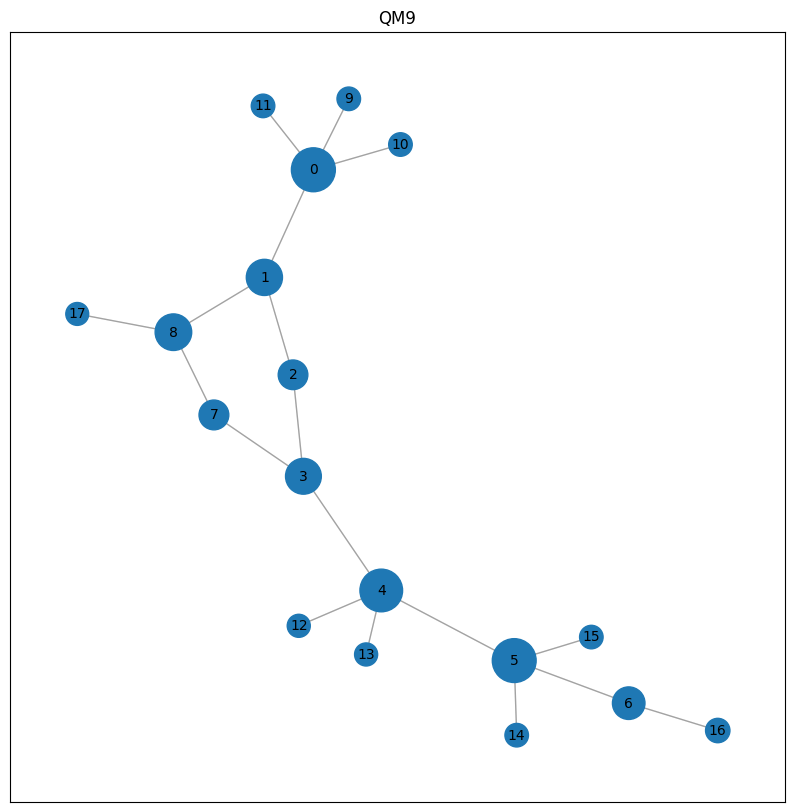

In [2]:
# グラフ構造の可視化
import networkx
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx

data = dataset[123125]
nxg = to_networkx(data)

pagerank = networkx.pagerank(nxg) #pagerankはノードの中心性(重要性の指標)
pagerank_max = np.array(list(pagerank.values())).max()

#可視化する時のノード位置
draw_position = networkx.spring_layout(nxg,seed=0)

# 色指定
color_map = plt.get_cmap("tab10")
labels = data.y.numpy()
colors = [color_map(i) for i in labels]

plt.figure(figsize=(10,10))
networkx.draw_networkx_nodes(nxg,
                            draw_position,
                            node_size=[v / pagerank_max * 1000 for v in pagerank.values()],
                            #node_color=colors, alpha=0.5
                            )

networkx.draw_networkx_edges(nxg, draw_position, arrowstyle='-', alpha=0.2)
networkx.draw_networkx_labels(nxg, draw_position, font_size=10)
 
plt.title('QM9')
plt.show()



Pytorch GeometricでGNNの入門
https://cpp-learning.com/pytorch-geometric/#PyTorch_Geometric

torch_geometric.datasets.QM9
https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html
parameters:
root
transform
pre_transform
pre_filter

In [4]:
size = len(dataset)
loader = torch_geometric.data.DataLoader(dataset[:int(size*0.8)],batch_size=64,shuffle=True)
test_loader = torch_geometric.data.DataLoader(dataset[int(size*0.8)],batch_size=64,shuffle=True)
nn = torch.nn

def mlp(input_dim, hidden_dim):
    return nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim,hidden_dim)
    )

class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.convs = nn.ModuleList() #modelをリスト形式で保存
        self.convs.append(torch_geometric.nn.GINConv(mlp(input_dim,hidden_dim)))
        for i in range(2):
            self.convs.append(torch_geometric.nn.GINConv(mlp(hidden_dim,hidden_dim)))
        self.head = nn.Sequential(
            nn.Linear(hidden_dim,hidden_dim),
            nn.Dropout(0.25),
            nn.Linear(hidden_dim,output_dim)
        )
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.25, training=self.training)
        x = torch_geometric.nn.global_mean_pool(x,batch)
        x = self.head(x)
        return x
        

/home/higuchi/mambaforge/envs/torchenv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


torch_geometric: これだけで

In [ ]:
loader.dataset.get(1)

In [ ]:
model = GNNModel(dataset.num_node_features, 32, dataset.num_classes)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_f = nn.MSELoss(reduction="sum")

for epoch in range(100):
    total_loss = 0
    model.train()
    for batch in tqdm(loader):
        opt.zero_grad()
        pred = model(batch)
        loss = loss_f(pred, batch.y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * batch.num_graphs
    total_loss /= len(loader.dataset)
    print("loss:", total_loss, epoch)        